In [2]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import evofr as ef
from evofr.models.mutational_fitness_mlr import MutationalFitnessMLR, MutationalFitnessSequenceCounts

In [3]:
# Getting data
raw_seq = pd.read_csv("../../sars2-epistasis-modeling/count-data/pango_location-variant-sequence-counts.tsv", sep="\t")
raw_seq = raw_seq[~raw_seq.variant.str.startswith("X")]
raw_muts = pd.read_csv("../../sars2-epistasis-modeling/mutations-by-variant/accumulated_mutations_output.tsv", sep="\t")
variant_frequencies = MutationalFitnessSequenceCounts(raw_seq, raw_muts)

In [4]:
# Defining model
mlr = MutationalFitnessMLR(tau=4.2)

In [5]:
# Defining inference method
inference_method = ef.InferMAP(iters=100_000, lr=4e-4)

In [6]:
# Fitting model
posterior = inference_method.fit(mlr, variant_frequencies)
samples = posterior.samples

## Plotting results

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 32}

matplotlib.rc('font', **font)

In [7]:
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]

In [8]:
from evofr.plotting import *

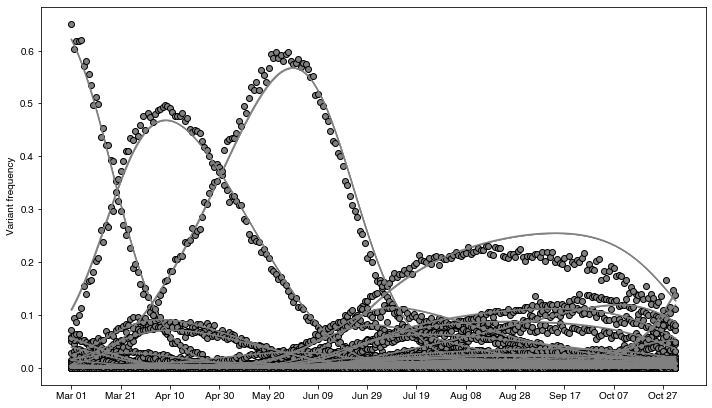

In [9]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

colors = ["grey" for v in variant_frequencies.var_names] # Mapping colors to observed variants

# Plot predicted frequencies
plot_posterior_frequency(ax, samples, ps, alphas, colors)
plot_observed_frequency(ax, variant_frequencies, colors) # Plot observed frequencies

add_dates_sep(ax, variant_frequencies.dates, sep=20) # Adding dates
ax.set_ylabel("Variant frequency") # Making ylabel

fig.tight_layout()
fig.subplots_adjust(bottom = 0.1)

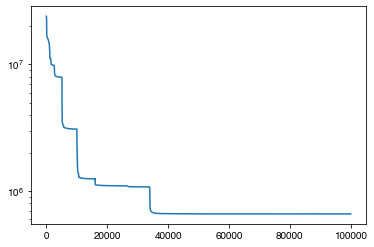

In [10]:
plt.plot(samples["losses"])
plt.yscale("log")

In [19]:
# Top 10 mutations
def top_n_mutations(samples, data, top_n = 20):
    delta = jnp.median(samples["raw_delta"], axis=0)
    idx = (-delta).argsort()[:top_n]
    return idx, data.mut_names[idx], delta[idx]

def top_n_variants(samples, data, top_n = 21769):
    beta = jnp.median(samples["beta"][:,-1,:], axis=0)
    idx = (-beta).argsort()[:top_n]
    return idx, np.array(data.var_names)[idx], beta[idx]

In [12]:
top_n_mutations(samples, variant_frequencies)

(DeviceArray([129, 153,   8, 127,  82,  83,  92,  51,  48,  20,  94,  56,
              142,   5,  58,  36, 145,  42, 126,  95], dtype=int32),
 array(['N460K', 'V1706I', 'I3758V', 'K444R', 'R1315C', 'T2163I', '-70V',
        'P13L', 'P681H', 'V70-', '-142D', '*420X', 'K147E', 'L2084X',
        'G204R', 'E484A', 'I210V', 'N679K', 'G257D', '-143V'], dtype=object),
 DeviceArray([1.0764167 , 0.83537287, 0.7763756 , 0.69959056, 0.61190045,
              0.5393059 , 0.5231332 , 0.46328327, 0.4544245 , 0.42509514,
              0.42261636, 0.381018  , 0.3749777 , 0.36293364, 0.34787786,
              0.34446102, 0.3376208 , 0.32794347, 0.32403377, 0.32193273],            dtype=float32))

In [22]:
top_variants = pd.DataFrame(top_n_variants(samples, variant_frequencies))

In [23]:
top_variants.to_csv('mutational_growth_advantages.tsv', sep="\t")

In [13]:
def plot_mutation_effects(ax, samples, data, top_n=None, color="grey"):
    if top_n is None:
        top_n = 1000
    mut_inds, mut_names, _ = top_n_mutations(samples, data, top_n)
    inds = jnp.arange(len(mut_inds))
    
    # Full set of samples
    delta = samples["raw_delta"][:, mut_inds]
    
    parts = ax.violinplot(delta.T, inds, showmeans=False, showmedians=False, showextrema=False, vert=True)

    for i, pc in enumerate(parts["bodies"]):
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    q1, med, q3 = jnp.percentile(delta, jnp.array([25, 50, 75]), axis=0)
    ax.scatter(inds, med,color="white", zorder=3, edgecolor="black")
    ax.vlines(inds, q1, q3, color="k", lw=4, zorder=2)

    q1, med, q3 = jnp.percentile(delta, jnp.array([2.5, 50, 97.5]), axis=0)
    ax.vlines(inds, q1, q3, color="k", lw=2, zorder=1)

    ax.set_xticks(inds)
    ax.set_xticklabels(mut_names, rotation=90)
    ax.set_ylabel("Fitness effect")
    return ax

<AxesSubplot: ylabel='Fitness effect'>

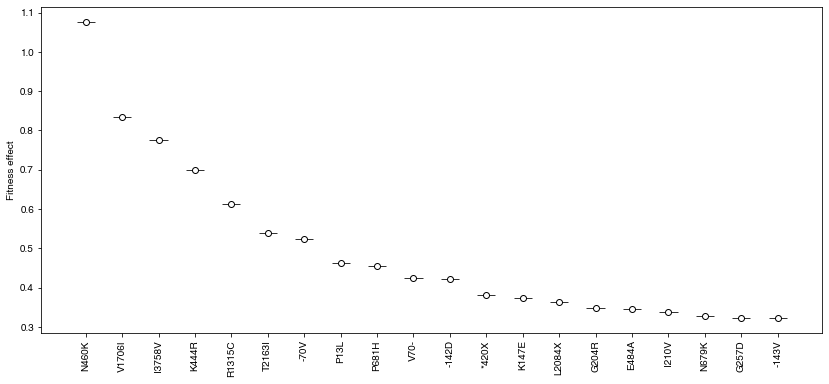

In [14]:
fig, gs = create_empty_gridspec(1, 1, figsize=(14,6))
ax = fig.add_subplot(gs[0])
ax = plot_mutation_effects(ax, samples, variant_frequencies, top_n=20)

ax

In [15]:
def plot_gas(ax, samples, data, top_n=None, color="grey"):
    if top_n is None:
        top_n = 1000
    v_inds, v_names, _ = top_n_variants(samples, data, top_n)
    inds = jnp.arange(len(v_inds))
    
    # Full set of samples
    gas = samples["ga"][:, v_inds]
    
    parts = ax.violinplot(gas.T, inds, showmeans=False, showmedians=False, showextrema=False, vert=True)

    for i, pc in enumerate(parts["bodies"]):
        pc.set_facecolor(color)
        pc.set_edgecolor("black")
        pc.set_alpha(0.8)

    q1, med, q3 = jnp.percentile(gas, jnp.array([25, 50, 75]), axis=0)
    ax.scatter(inds, med,color="white", zorder=3, edgecolor="black")
    ax.vlines(inds, q1, q3, color="k", lw=4, zorder=2)

    q1, med, q3 = jnp.percentile(gas, jnp.array([2.5, 50, 97.5]), axis=0)
    ax.vlines(inds, q1, q3, color="k", lw=2, zorder=1)

    ax.set_xticks(inds)
    ax.set_xticklabels(v_names, rotation=90)
    ax.set_ylabel("Growth advantage")
    return ax

<AxesSubplot: ylabel='Growth advantage'>

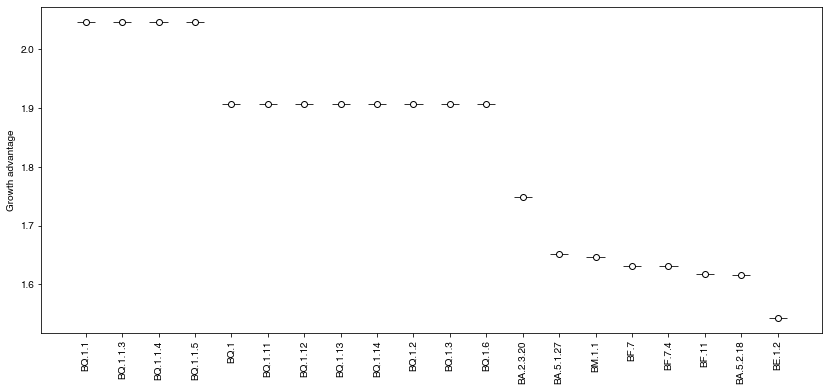

In [16]:
fig, gs = create_empty_gridspec(1, 1, figsize=(14,6))
ax = fig.add_subplot(gs[0])
ax = plot_gas(ax, samples, variant_frequencies, top_n=20)

ax

In [17]:
import matplotlib as mpl

def binary_colormap():
    # define the colors
    cmap = mpl.colors.ListedColormap(['#FFC0CB', '#ADFF9E'])

    # create a normalize object the describes the limits of
    # each color
    bounds = [0., 0.5, 1.]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cmap, norm

def plot_presence_top_mutations_top_variants(ax, samples, data, top_m, top_v):
    # Rank top_m, top_v
    if top_m is None:
        top_m = 10_000

    if top_v is None:
        top_v = 10_000
    
    mut_inds, mut_names, _ = top_n_mutations(samples, data, top_m)
    v_inds, var_names, _ = top_n_variants(samples, data, top_v)

    mut_ticks = np.arange(len(mut_names))
    var_ticks = -np.arange(len(var_names))
    # Use data to see if that mutation is present for that variant
    presence = jnp.take(jnp.take(data.mutation_presence, v_inds, axis=0), mut_inds, axis=1)

    cmap, norm = binary_colormap()
    #im = ax.imshow(presence, cmap=cmap)
    #fig.colorbar(im, orientation='vertical', flipy=True)
    for m, mut in enumerate(mut_names):
        # Basically filter
        #xs will be m values
        ys = var_ticks[presence[:, m] > 0]
        xs = [mut_ticks[m]] * len(ys)
        ax.scatter(xs, var_ticks[presence[:, m] > 0], s = 500, color=cmap(1.), ec="k")
    
    
    # Labeling
    ax.set_xlabel("Mutations")
    ax.set_xticks(mut_ticks)
    ax.set_xticklabels(mut_names, rotation=90)
    
    ax.set_ylabel("Variants")
    ax.set_yticks(var_ticks)
    ax.set_yticklabels(var_names)

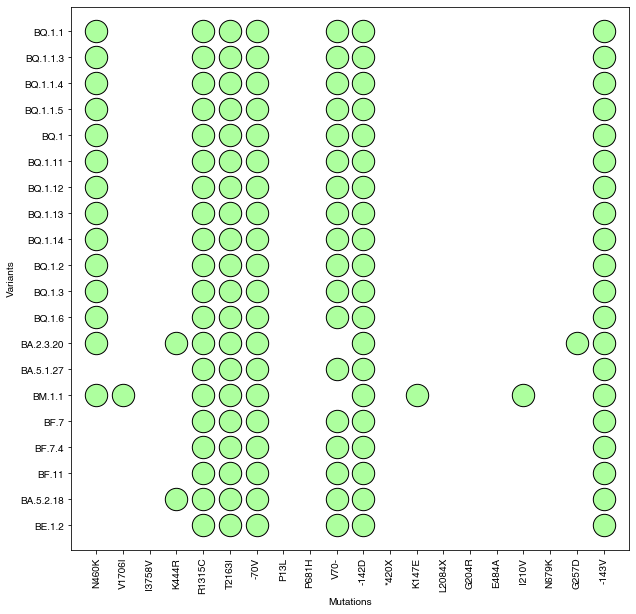

In [18]:
fig, gs = create_empty_gridspec(1, 1, figsize=(10,10))
ax = fig.add_subplot(gs[0])
ax = plot_presence_top_mutations_top_variants(ax, samples, variant_frequencies, top_m=20, top_v=20)

ax

In [7]:
ga_df = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples, posterior.data, ps=[0.8], name="USA", rel_to="BA.2")
)

In [9]:
ga_df.to_csv('mutational_growth_advantages.tsv', sep="\t")